# general imports

In [1]:
from __future__ import division, print_function

import os

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# sets the PyHEADTAIL directory etc.
try:
    from settings import *
except:
    pass

# PySussix imports

Sussix is a tune analysis tool: https://cds.cern.ch/record/702438/files/sl-note-98-017.pdf .
If you do not have PySussix, its python interface, find it under https://github.com/PyCOMPLETE/PySussix .

In [3]:
try:
    from PySussix import Sussix
except ImportError:
    print ('ERROR: This interactive test needs the PySussix module. Trying PySUSSIX')
    from PySUSSIX import Sussix
    print('PySUSSIX found')

# PyHEADTAIL imports

In [4]:
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.longitudinal_tracking import LinearMap
from PyHEADTAIL.rfq.rfq import RFQLongitudinalKick, RFQTransverseKick, RFQTransverseDetuner
import PyHEADTAIL.particles.generators as generators

PyHEADTAIL v1.12.4.7




# Setting up the machine and functions

In [5]:
# Basic parameters.
n_turns = 500
n_segments = 5
n_macroparticles = 500

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376
alpha_0 = [0.0003225]

# Parameters for transverse map.
s = np.arange(0, n_segments + 1) * C / n_segments

alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
D_x = np.zeros(n_segments)

alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)
D_y = np.zeros(n_segments)

# HELPERS
def gimme(*detuners):
    trans_map = TransverseMap(
        s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y, detuners)
    long_map = LinearMap(alpha_0, C, Q_s)
    bunch = generate_bunch(
        n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,
        long_map)
    return bunch, trans_map, long_map

def calc_sussix_spec(x, xp, y, yp, p_idx, turn, window_width, q_x, q_y, n_lines=10):
    # Initialise Sussix object
    SX = Sussix()
    SX.sussix_inp(nt1=1, nt2=window_width, idam=2, ir=0, tunex=q_x, tuney=q_y)

    tunes_x = np.empty(n_lines)
    tunes_y = np.empty(n_lines)

    SX.sussix(x[p_idx,turn:turn+window_width], xp[p_idx,turn:turn+window_width],
              y[p_idx,turn:turn+window_width], yp[p_idx,turn:turn+window_width],
              # this line is not used by sussix:
              x[p_idx,turn:turn+window_width], xp[p_idx,turn:turn+window_width])

    os.remove('sussix.inp')

    return SX.ox[:n_lines], SX.oy[:n_lines]

def track_n_save(bunch, map_):
    n_particles = bunch.macroparticlenumber
    x_i = np.empty((n_particles, n_turns))
    xp_i = np.empty((n_particles, n_turns))
    y_i = np.empty((n_particles, n_turns))
    yp_i = np.empty((n_particles, n_turns))

    for i in range(n_turns):
        x_i[:,i] = bunch.x[:]
        xp_i[:,i] = bunch.xp[:]
        y_i[:,i] = bunch.y[:]
        yp_i[:,i] = bunch.yp[:]
   
        for m_ in map_:
            m_.track(bunch)

    return x_i, xp_i, y_i, yp_i

def analyse_n_plot(bunch, x_i, xp_i, y_i, yp_i):
    ox = np.empty(bunch.macroparticlenumber)
    oy = np.empty(bunch.macroparticlenumber)
    print ('analysing particle spectra ... this may take some time.')
    for p_idx in range(bunch.macroparticlenumber):
        ox[p_idx], oy[p_idx] = calc_sussix_spec(x_i, xp_i, y_i, yp_i, p_idx,
                                   turn=0, window_width=512, q_x=Q_x%1, q_y=Q_y%1, n_lines=1)
        if (p_idx)%100 == 0:
            print ('particle', p_idx)

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax1.scatter(ox, oy)
    ax1.set_ylabel(r'$Q_y$', fontsize=20)
    ax1.set_xlabel(r'$Q_x$', fontsize=20)
    ax2.hist(ox, bins=50, color='blue')
    ax2.set_xlabel(r'$Q_x$', fontsize=20)
    ax3.hist(oy, bins=50, color='red')
    ax3.set_xlabel(r'$Q_y$', fontsize=20)
    
    print ('std dev. Qx', np.std(ox))
    print ('std dev. Qy', np.std(oy))
    
    plt.tight_layout()
    plt.show()

def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Q_s))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e) 

    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

# Let's go

### RFQ Detuner Model in Transverse Plane

The transverse action of the radio frequency quadrupole can be modelled as a detuner:

analysing particle spectra ... this may take some time.
particle 0
particle 100
particle 200
particle 300
particle 400
std dev. Qx 0.000337824100269
std dev. Qy 0.000168930881075


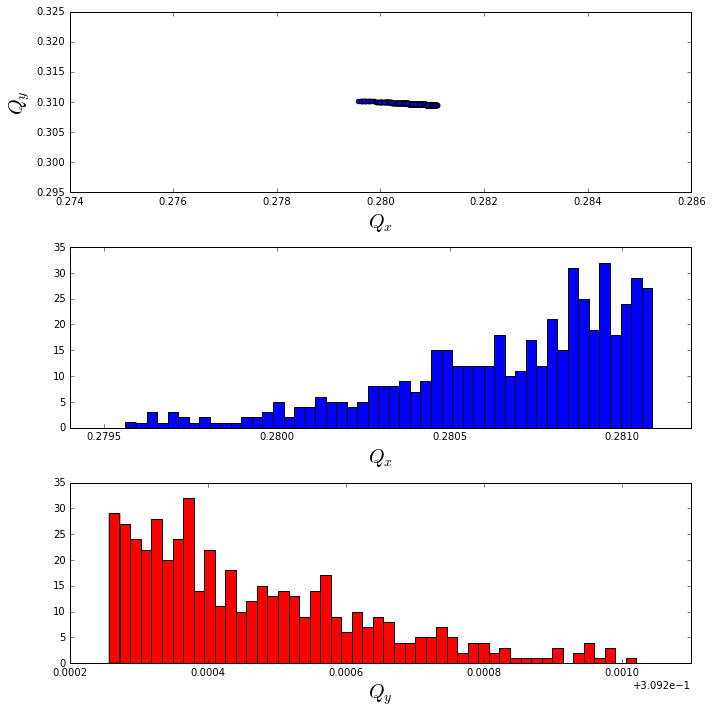

In [6]:
# EXPECTED TUNE SPREADS AT THE GIVEN SETTINGS ARE 3.4e-4 FOR HORIZONTAL
# AND 1.7e-4 FOR VERTICAL.
rfq_t = RFQTransverseDetuner(v_2=2e9, omega=800e6*2.*np.pi, phi_0=0.,
                             beta_x_RFQ=200., beta_y_RFQ=100.)
bunch, trans_map, long_map = gimme(rfq_t)

trans_one_turn = [m for m in trans_map]
map_ = trans_one_turn + [long_map]

x_i, xp_i, y_i, yp_i = track_n_save(bunch, map_)
analyse_n_plot(bunch, x_i, xp_i, y_i, yp_i)

### RFQ Kick Model in Transverse Plane

The transverse action of the radio frequency quadrupole can also be modelled as a localised kick:

analysing particle spectra ... this may take some time.
particle 0
particle 100
particle 200
particle 300
particle 400
std dev. Qx 0.000116336238228
std dev. Qy 0.000126056503973


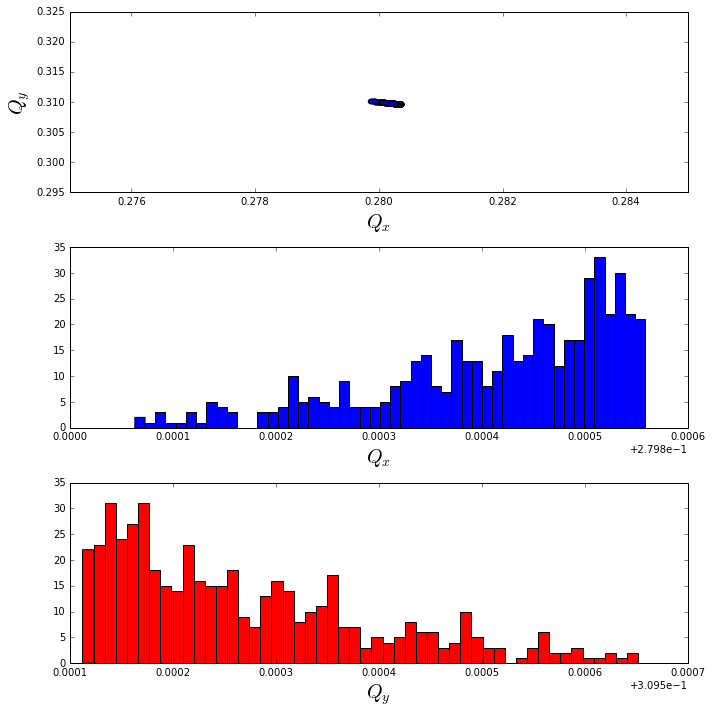

In [7]:
# EXPECTED TUNE SPREADS AT THE GIVEN SETTINGS ARE ROUGHLY 1.2e-4 FOR HORIZONTAL
# AND FOR VERTICAL.
rfq_t = RFQTransverseKick(v_2=2e9, omega=800e6*2.*np.pi, phi_0=0.)
bunch, trans_map, long_map = gimme()

trans_one_turn = [m for m in trans_map]
map_ = trans_one_turn + [long_map] + [rfq_t]

x_i, xp_i, y_i, yp_i = track_n_save(bunch, map_)
analyse_n_plot(bunch, x_i, xp_i, y_i, yp_i)

### RFQ Detuner Model in Longitudinal Plane

The action of the radio frequency quadrupole in the longitudinal plane is usually weaker than in the transverse plane. Here, the detuner model provided by PyHEADTAIL should be sufficient:

analysing particle spectra ... this may take some time.
particle 0
particle 100
particle 200
particle 300
particle 400
std dev. Qx 2.65802146125e-06
std dev. Qy 2.80869921413e-06


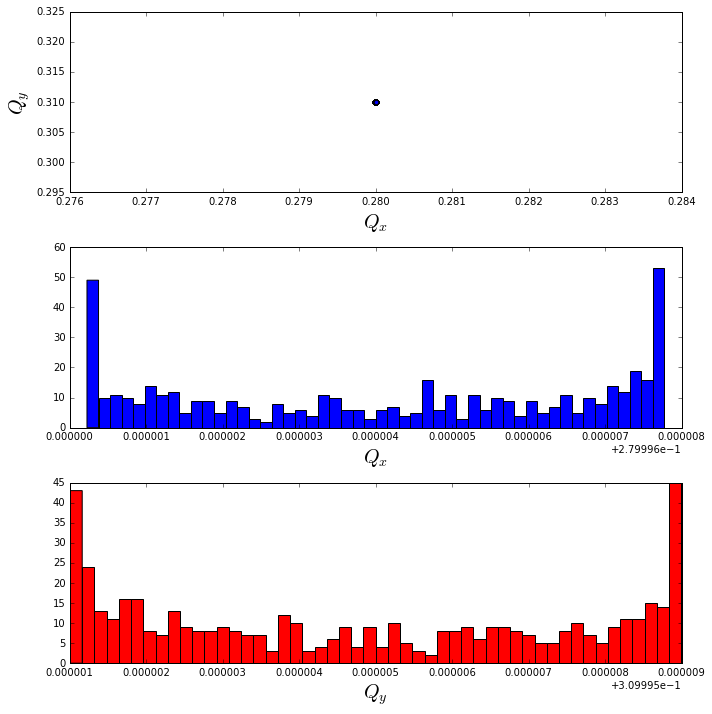

In [8]:
# NEGLIGIBLE TUNE SPREADS EXPECTED.
rfq_long = RFQLongitudinalKick(v_2=2e9, omega=800e6*2.*np.pi, phi_0=0.)

bunch, trans_map, long_map = gimme()
trans_one_turn = [ m for m in trans_map ]
map_ = trans_one_turn + [long_map] + [rfq_long]

x_i, xp_i, y_i, yp_i = track_n_save(bunch, map_)
analyse_n_plot(bunch, x_i, xp_i, y_i, yp_i)